In [1]:
import numpyro
import jax.numpy as jnp
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS 

from numpyro.handlers import reparam,condition,trace,seed
from numpyro.infer.reparam import LocScaleReparam
from typing import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import VIPReparam

from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam

numpyro.set_platform("cpu")
numpyro.set_host_device_count(10)

In [2]:
def neal_funnel(obs : jnp.ndarray, noise = 0.1):
    with numpyro.plate("obs_batch",obs.shape[1]):
        x = numpyro.sample("x",dist.Normal(0,1))
        y = numpyro.sample("y",dist.Normal(0,jnp.exp(x)))
        with numpyro.plate("obs_num",obs.shape[0]):
            numpyro.sample("obs", dist.Normal(y,noise),obs)
        

In [11]:
model = seed(neal_funnel, random.PRNGKey(0))
obs_t = jnp.transpose(jnp.array([[20,20]]))
print(numpyro.util.format_shapes(trace(model).get_trace(obs_t)))

  Trace Shapes:      
   Param Sites:      
  Sample Sites:      
obs_batch plate   1 |
         x dist   1 |
          value   1 |
         y dist   1 |
          value   1 |
  obs_num plate   1 |
       obs dist 1 1 |
          value 1 1 |


In [4]:
obs1 = jnp.linspace(-40,40,41)
obs2 = jnp.linspace(-40,40,41)

obs_list = jnp.meshgrid(obs2, obs1)
obs = jnp.stack([obs_list[0],obs_list[1]],2)
obs_f = jnp.transpose(jnp.reshape(obs, (-1,2)))

  Trace Shapes:              
   Param Sites:              
  Sample Sites:              
obs_batch plate           1 |
         x dist           1 |
          value 1000000 1 1 |
         y dist 1000000 1 1 |
          value 1000000 1 1 |
  obs_num plate           2 |
       obs dist 1000000 2 1 |
          value         2 1 |
x
(1000000, 1, 1)
(1,)
y
(1000000, 1, 1)
(1000000, 1, 1)
obs
(1000000, 2, 1)
(1000000, 2, 1)
-1101354.2
-5.0


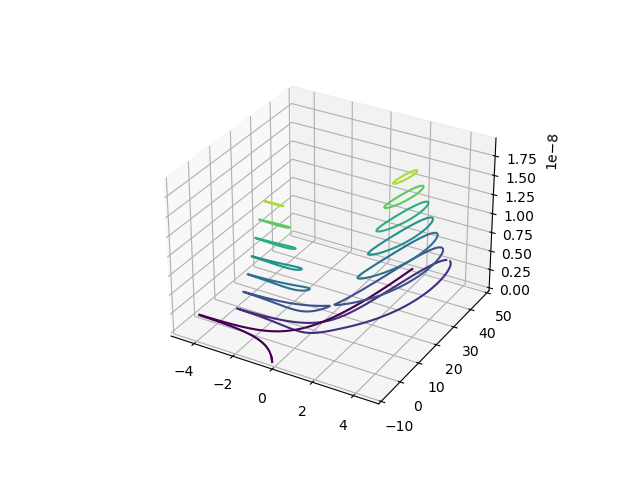

In [32]:
%matplotlib widget
### neal_funnel log_prob plot ###

obs_lp = obs_t

xmin = -5
xmax = 5
ymin = -10
ymax = 50

xs_r, ys_r = jnp.meshgrid(jnp.linspace(xmin,xmax,1000), jnp.linspace(ymin,ymax,1000))

xs = jnp.reshape(xs_r, (-1,1,1))
ys = jnp.reshape(ys_r, (-1,1,1))


model = seed(neal_funnel, random.PRNGKey(0))
exec_trace = trace(condition(model, {'x': xs, 'y': ys})).get_trace(jnp.transpose(jnp.array([[40, 40]])),noise = 13)

print(numpyro.util.format_shapes(exec_trace))

def unnormal_log_prob_nf(tr):
    prob = 0
    prob += tr["x"]["fn"].log_prob(tr["x"]["value"]).sum(1)
    prob += tr["y"]["fn"].log_prob(tr["y"]["value"]).sum(1)
    
    prob += tr["obs"]["fn"].log_prob(tr["obs"]["value"]).sum(1)
    for key,value in tr.items():
        if value["type"] == "sample":
            print(key)
            print(value["fn"].log_prob(value["value"]).shape)
            print(value["fn"].sample(random.PRNGKey(0)).shape)

    return prob

unnormal_probs = unnormal_log_prob_nf(exec_trace)

for i in range(unnormal_probs.shape[1]):
    lp_r = jnp.reshape(unnormal_probs[:,i], xs_r.shape)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.contour(xs_r,ys_r,jnp.exp(lp_r))

    print(lp_r[0,0])
    print(xs_r[0,0])

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    plt.show()

    Trace Shapes:              
     Param Sites:              
    Sample Sites:              
  obs_batch plate           1 |
           x dist           1 |
            value 1000000 1 1 |
y_decentered dist 1000000 1 1 |
            value 1000000 1 1 |
    obs_num plate           2 |
         obs dist 1000000 2 1 |
            value         2 1 |
x
(1000000, 1, 1)
(1,)
y_decentered
(1000000, 1, 1)
(1000000, 1, 1)
obs
(1000000, 2, 1)
(1000000, 2, 1)
-1573.3947
-25.0


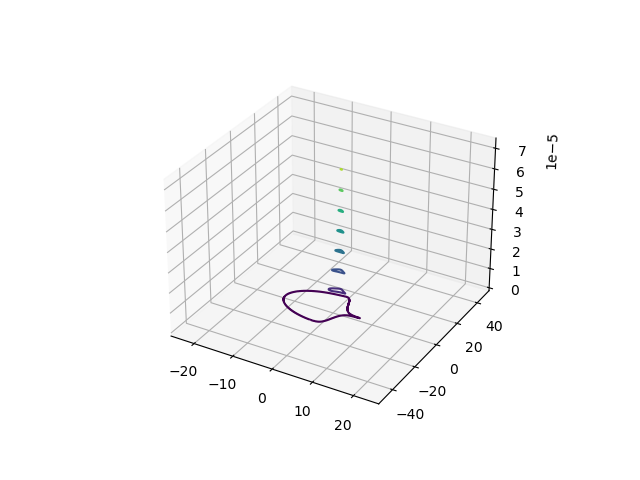

In [6]:
%matplotlib widget
### neal_funnel log_prob plot ###

obs_lp = obs_t

xmin = -25
xmax = 25
ymin = -50
ymax = 50

xs_r, ys_r = jnp.meshgrid(jnp.linspace(xmin,xmax,1000), jnp.linspace(ymin,ymax,1000))

xs = jnp.reshape(xs_r, (-1,1,1))
ys = jnp.reshape(ys_r, (-1,1,1))

reparam_model = reparam(neal_funnel, config={"y": VIPReparam.LocScaleReparam2(0,batch_depth=1)})
model = seed(reparam_model, random.PRNGKey(0))
exec_trace = trace(condition(model, {'x': xs, 'y_decentered': ys})).get_trace(jnp.transpose(jnp.array([[10,10]])), noise = 5)

print(numpyro.util.format_shapes(exec_trace))

def unnormal_log_prob_nf(tr):
    prob = 0
    prob += tr["x"]["fn"].log_prob(tr["x"]["value"]).sum(1)
    prob += tr["y_decentered"]["fn"].log_prob(tr["y_decentered"]["value"]).sum(1)
    
    prob += tr["obs"]["fn"].log_prob(tr["obs"]["value"]).sum(1)
    for key,value in tr.items():
        if value["type"] == "sample":
            print(key)
            print(value["fn"].log_prob(value["value"]).shape)
            print(value["fn"].sample(random.PRNGKey(0)).shape)

    return prob

unnormal_probs = unnormal_log_prob_nf(exec_trace)

for i in range(unnormal_probs.shape[1]):
    lp_r = jnp.reshape(unnormal_probs[:,i], xs_r.shape)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.contour(xs_r,ys_r,jnp.exp(lp_r))

    print(lp_r[0,0])
    print(xs_r[0,0])

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    plt.show()

In [7]:
reparam_model = reparam(neal_funnel, config={"y": VIPReparam.LocScaleReparam2(0.8,batch_depth=1)})
nuts_kernel2 = NUTS(reparam_model)
mcmc2 = MCMC(nuts_kernel2, num_warmup=100, num_samples=500 ,num_chains=10)
rng_key2 = random.PRNGKey(0)
mcmc2.run(rng_key2, jnp.transpose(jnp.array([[20,20]])), noise=5, extra_fields=('num_steps',))
mcmc2.print_summary()

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           x[0]      2.38      0.45      2.35      1.66      3.10   2458.63      1.00
y_decentered[0]     10.83      2.12     10.88      7.32     14.30   2430.73      1.00

Number of divergences: 1


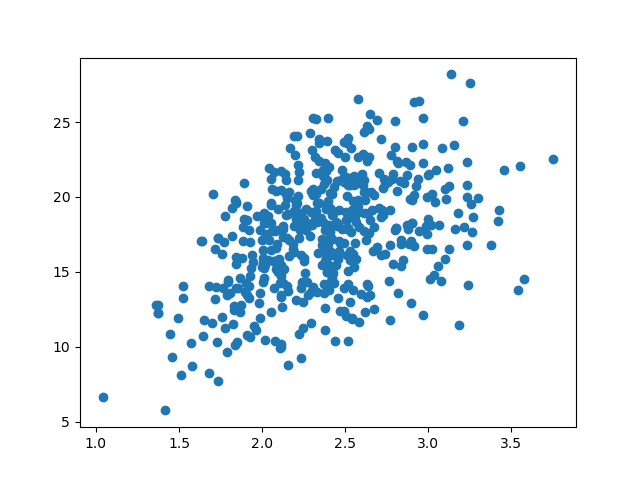

In [36]:
smps = mcmc2.get_samples()
plt.figure()
plt.scatter(smps["x"],smps["y"])
plt.show()

In [8]:
from importlib import reload
reload(VIPReparam)
import VIPReparam

noises = jnp.linspace(0.5,5,10)
#noises = (0.1,)
vip_list = []

for noise in noises:
    optimizer = Adam(step_size = 0.01)

    learnable_model = reparam(neal_funnel, config={"y": VIPReparam.LocScaleReparam2(batch_depth=1)})

    # setup the inference algorithm
    svi = SVI(learnable_model, AutoNormal(learnable_model), optimizer, loss=Trace_ELBO())

    # do gradient steps
    svi_result = svi.run(random.PRNGKey(100), 20000, jnp.array(obs_f),noise)
    vip_list.append(jnp.copy(svi_result.params["y_centered"]))

    # plt.figure()
    # plt.plot(svi_result.losses)
    # plt.show()




100%|██████████| 20000/20000 [00:18<00:00, 1068.50it/s, init loss: 55629.8008, avg. loss [19001-20000]: 34364.6602]


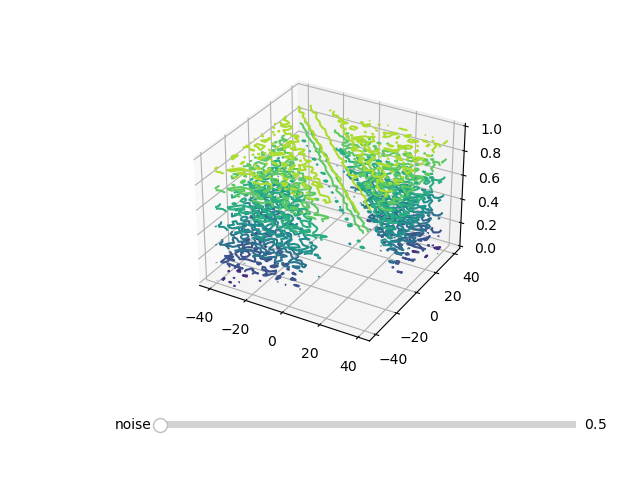

(DeviceArray([1], dtype=int32),)
(DeviceArray([0], dtype=int32),)
(DeviceArray([1], dtype=int32),)
(DeviceArray([2], dtype=int32),)
(DeviceArray([3], dtype=int32),)
(DeviceArray([4], dtype=int32),)
(DeviceArray([5], dtype=int32),)
(DeviceArray([6], dtype=int32),)
(DeviceArray([7], dtype=int32),)
(DeviceArray([8], dtype=int32),)
(DeviceArray([9], dtype=int32),)
(DeviceArray([8], dtype=int32),)
(DeviceArray([7], dtype=int32),)
(DeviceArray([6], dtype=int32),)
(DeviceArray([5], dtype=int32),)
(DeviceArray([4], dtype=int32),)
(DeviceArray([3], dtype=int32),)
(DeviceArray([2], dtype=int32),)
(DeviceArray([1], dtype=int32),)
(DeviceArray([0], dtype=int32),)
(DeviceArray([1], dtype=int32),)
(DeviceArray([2], dtype=int32),)
(DeviceArray([3], dtype=int32),)
(DeviceArray([4], dtype=int32),)
(DeviceArray([3], dtype=int32),)
(DeviceArray([2], dtype=int32),)
(DeviceArray([1], dtype=int32),)
(DeviceArray([0], dtype=int32),)
(DeviceArray([1], dtype=int32),)
(DeviceArray([2], dtype=int32),)
(DeviceArr

In [9]:
%matplotlib widget

plt.clf()
ax = plt.subplot(projection="3d")
ax.set_zlim(0, 1)
fig = ax.get_figure()

fig.subplots_adjust(bottom=0.25)
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
noise_slider = Slider(
    ax=axfreq,
    label='noise',
    valmin=noises[0],
    valmax=noises[-1],
    valstep=noises,
    valinit=noises[0],
)
ax.contour3D(obs[...,0],obs[...,1],jnp.reshape(vip_list[0],(41,41)))

# for i,vips in enumerate(vip_list):

#     print(i, noises[i], str(noises[i]))
#     #ax.plot(obs_f[0,:],vips,label=str(noises[i]))
#     #if i == 9:
#     surf = ax.plot_surface(obs[...,0],obs[...,1],jnp.reshape(vips,(20,20)))
    
#     #fake2Dline = plt.Line2D([0],[0], linestyle="none", c=surf._facecolors3d, marker = 'o',label=str(noises[i]))


def update(val):
    print(jnp.where(noises == val))
    idx = jnp.where(noises == val)[0][0]
    ax.clear()
    ax.contour3D(obs[...,0],obs[...,1],jnp.reshape(vip_list[idx],(41,41)))
    ax.set_zlim(0, 1)

noise_slider.on_changed(update)

plt.show()